# Loading Dataset

In [1]:
DATA_PATH = "gender_dataset/"

# Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt

# Image Preprocessing

In [3]:
train_datagen = ImageDataGenerator( # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    rescale = 1./255, #Convert color scale from 0-1 to 0-255 range
    rotation_range=5, #randomly rotate image between 0 and 5 degrees
    shear_range = 0.1, #To let computer read images from different angle
    zoom_range = 0.1, #Range for random zoom
    width_shift_range=0.2,  #Range for random horizontal shifts.
    height_shift_range=0.2, #Range for random vertical shifts.
    horizontal_flip=True, #Randomly flip inputs horizontally.
)

test_datagen = ImageDataGenerator(
   rescale = 1./255 
)

In [4]:
train_data = train_datagen.flow_from_directory(
  DATA_PATH+'Training/',
  target_size = (224, 224), #Image target Size
  color_mode = 'rgb', #the images will be converted to have 3 color channels.
  classes = ['females', 'males', 'unknown'], #classes
  class_mode = 'categorical', #categorical means more than 2 classes
  batch_size = 40, #size of the batches of data
  shuffle = True #Shuffle the images
)

test_data = test_datagen.flow_from_directory(
  DATA_PATH+'Validation/',
  target_size = (224, 224),
  color_mode = 'rgb',
  classes = ['females', 'males', 'unknown'],
  class_mode = 'categorical',
  batch_size = 40,
)

Found 11995 images belonging to 3 classes.
Found 2992 images belonging to 3 classes.


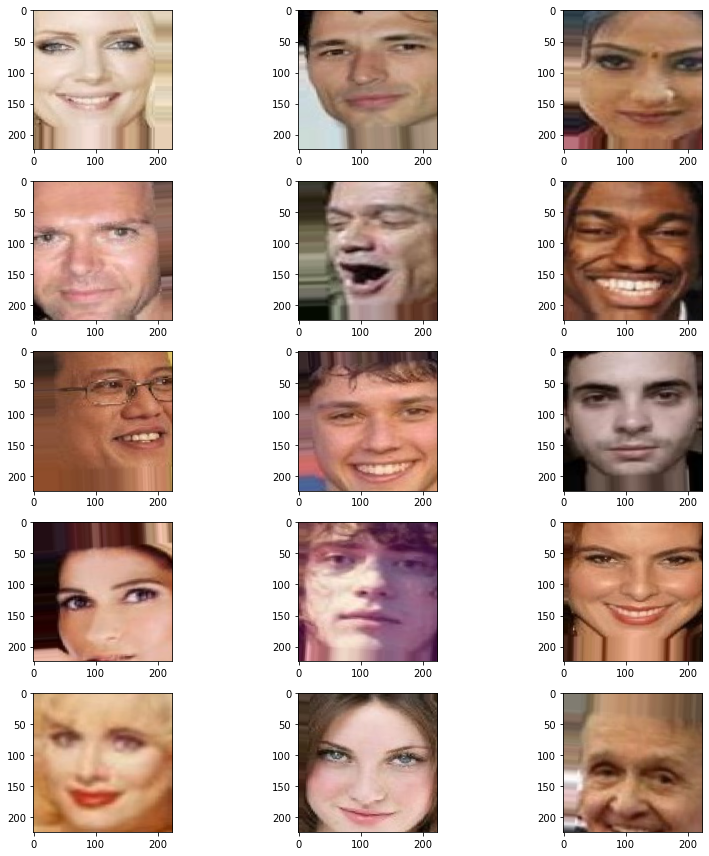

In [5]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5, 3, 1+i)
  for X_batch, Y_batch in train_data:
    image = X_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

# Modelling

In [6]:
model1 = Sequential() #Model is sequential (Single input and output)

model1.add(Conv2D(64, kernel_size=(3,3),  input_shape=(224,224,3), #64 neurons with 3x3 filter
                  activation='relu')) #relu remove negative values and replace it with zeros
#this class allows create CNN to extract feature
model1.add(MaxPool2D(pool_size=(2,2)))
#pooling reduces the size of the images while preserving their important characteristics


model1.add(Conv2D(32, activation='relu', kernel_size=(3,3)))
model1.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))


model1.add(Conv2D(32, activation='relu', kernel_size=(3,3))) 
model1.add(MaxPool2D(pool_size=(2,2)))


model1.add(Conv2D(128, activation='relu', kernel_size=(3,3))) 
model1.add(MaxPool2D(pool_size=(2,2)))


model1.add(Conv2D(64, activation='relu', kernel_size=(3,3))) 
model1.add(MaxPool2D(pool_size=(2,2)))

# Fully Connected Layer
model1.add(Flatten()) #flattens the multi-dimensional input tensors into a single dimension,
model1.add(Dense(128)) 
model1.add(Activation('relu'))
model1.add(Dense(3, activation = 'softmax')) #Softmax is best used for multi-classification
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [7]:
# Model Callback - Stop the training when no learning is taking place
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [early_stop]

In [8]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
#Adam easily adapts the learning rate

# Model Training

In [9]:
history = model1.fit(
    train_data,
    # Number of batches for training
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    # Number of batches for testing
    validation_steps = len(test_data),
    epochs = 8,
    callbacks = callbacks_list,
)

Epoch 1/8
300/300 [==============================] - 541s 2s/step - loss: 0.7087 - accuracy: 0.5994 - val_loss: 0.6321 - val_accuracy: 0.6955
Epoch 2/8
300/300 [==============================] - 528s 2s/step - loss: 0.5308 - accuracy: 0.7571 - val_loss: 0.3513 - val_accuracy: 0.8563
Epoch 3/8
300/300 [==============================] - 528s 2s/step - loss: 0.3598 - accuracy: 0.8496 - val_loss: 0.2535 - val_accuracy: 0.9084
Epoch 4/8
300/300 [==============================] - 528s 2s/step - loss: 0.2801 - accuracy: 0.8892 - val_loss: 0.2322 - val_accuracy: 0.9074
Epoch 5/8
300/300 [==============================] - 529s 2s/step - loss: 0.2580 - accuracy: 0.8976 - val_loss: 0.2239 - val_accuracy: 0.9178
Epoch 6/8
300/300 [==============================] - 533s 2s/step - loss: 0.2170 - accuracy: 0.9172 - val_loss: 0.1796 - val_accuracy: 0.9308
Epoch 7/8
300/300 [==============================] - 518s 2s/step - loss: 0.2051 - accuracy: 0.9207 - val_loss: 0.1719 - val_accuracy: 0.9425
Epoch 

# Save the model 

In [10]:
model1.save('gender_model.h5')

# Model accuracy

In [11]:
print("[INFO] accuracies....")  
# Train accuracy
scores = model1.evaluate(train_data, steps=len(train_data), verbose=1)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

# Test accuracy
scores = model1.evaluate(test_data, steps=len(test_data), verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

[INFO] accuracies....
300/300 [==============================] - 150s 499ms/step - loss: 0.1866 - accuracy: 0.9280
Train Accuracy: 92.80%
75/75 [==============================] - 22s 287ms/step - loss: 0.1745 - accuracy: 0.9372
Test Accuracy: 93.72%


# Plot the graph

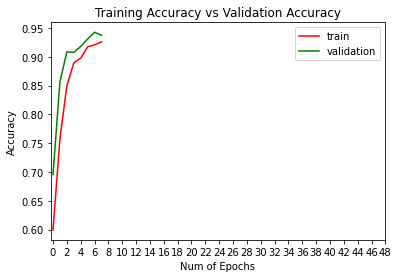

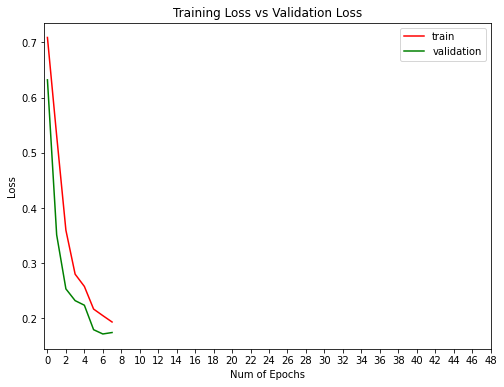

In [12]:
import numpy as np
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 50, 2))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0,50, 2))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

# Confusion Matrix

[INFO] evaluating the model...
              precision    recall  f1-score   support

     females       0.50      0.52      0.51      1464
       males       0.50      0.48      0.49      1464
     unknown       0.05      0.06      0.05        64

    accuracy                           0.49      2992
   macro avg       0.35      0.35      0.35      2992
weighted avg       0.49      0.49      0.49      2992



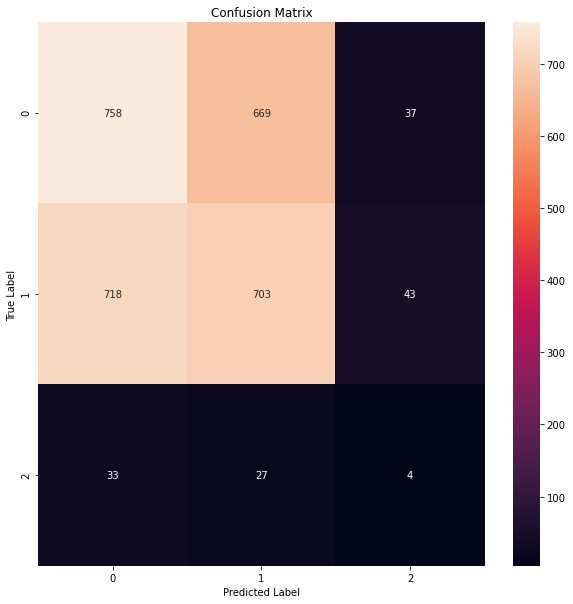

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
%matplotlib inline

# Reset the validation generator and evaluate the network after fine-tuning just the network head
print("[INFO] evaluating the model...")
test_data.reset()
plt.figure(figsize=(10,10))
predIdxs = model1.predict(test_data, steps = len(test_data))
predIdxs = np.argmax(predIdxs, axis=1)
matrix = confusion_matrix(test_data.classes, predIdxs)
sns.heatmap(matrix, annot=True, cbar=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

print(classification_report(test_data.classes, predIdxs, target_names=test_data.class_indices.keys()))

In [14]:
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2

img_path = 'gender_dataset/dog.jpg'

#img_path = mpimg.imread(14838)
#plt.imshow(img_path)
#plt.show()


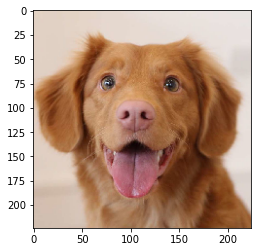

In [15]:
img = image.load_img(img_path, target_size=(224,224,3))
plt.imshow(img)

In [16]:
img = image.img_to_array(img)
img = img/225.0
img = img.reshape(1,224,224,3)
img.shape

(1, 224, 224, 3)

In [17]:
pred = model1.predict(img) #Predict the class of the img
pred

array([[5.5957942e-05, 1.4206537e-03, 9.9852341e-01]], dtype=float32)

In [18]:
ind = np.where(pred[0] == np.amax(pred[0]))
ind

(array([2], dtype=int64),)

In [19]:
i = ind[0][0]
i

2

In [20]:
dic = {0 : 'females', 1 : 'males', 2 : 'unknown'}
dic[i]

'unknown'

In [21]:
train_data.class_indices

{'females': 0, 'males': 1, 'unknown': 2}